## Data Loading & Pre-processing


In [1]:
!pip install scikit-learn pandas lightgbm

In [2]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [4]:
test_data = pd.read_csv('test_data.csv')

In [5]:
test_data.columns

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admit_provider_id', 'admission_location',
       'discharge_location', 'insurance', 'language', 'marital_status', 'race',
       'edregtime', 'edouttime', 'hospital_expire_flag', 'hosp_los',
       'adm_inhosp', 'icd9_sepsiscode', 'icd9_septicshock', 'icd10_sepsiscode',
       'icd10_septicshock', 'icd_version', 'icd9_angus', 'icd10_angus',
       'icd9_angus_over', 'icd10_angus_over', 'icd9_sepsiscode_over',
       'icd10_sepsiscode_over', 'sepsis', 'sepsistype', 'sepsistype_three',
       'anchor_age', 'age', 'gender', 'dod', 'older_adult',
       'discharge_location_factor', 'race_cate', 'race_tetra', 'race_tricho',
       'marital_dichotomous', 'insurance_dicho', 'admission_type_cate',
       'prev90d', 'prev90d_hosp', 'prev90d_hosp_sum', 'icu_hx', 'comorbidity',
       'nextadm30d', 'rehosp30d', 'nextadm7d', 'rehosp7d', 'nextadm30d_date',
       'died30d', 'died30d_noreadm', 'nextadm7d

## EDA

In [ ]:
test_data['rehosp7d'].value_counts()

,count
rehosp7d,
0,7888
1,910


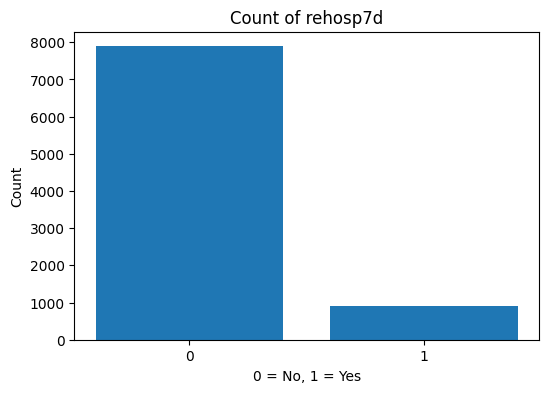

In [ ]:
# Plot rehospitalization rate of 7 days
counts = test_data['rehosp7d'].value_counts()

plt.figure(figsize=(6, 4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Count of rehosp7d")
plt.xlabel("0 = No, 1 = Yes")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

In [ ]:
test_data['rehosp30d'].value_counts()

,count
rehosp30d,
0,6280
1,2518


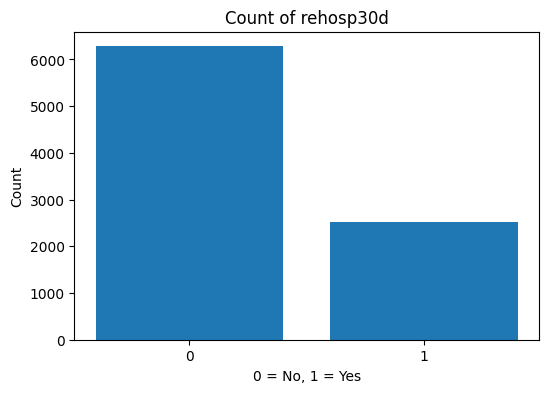

In [ ]:
# Plot rehospitalization rate of 30 days
counts = test_data['rehosp30d'].value_counts()

plt.figure(figsize=(6, 4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Count of rehosp30d")
plt.xlabel("0 = No, 1 = Yes")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

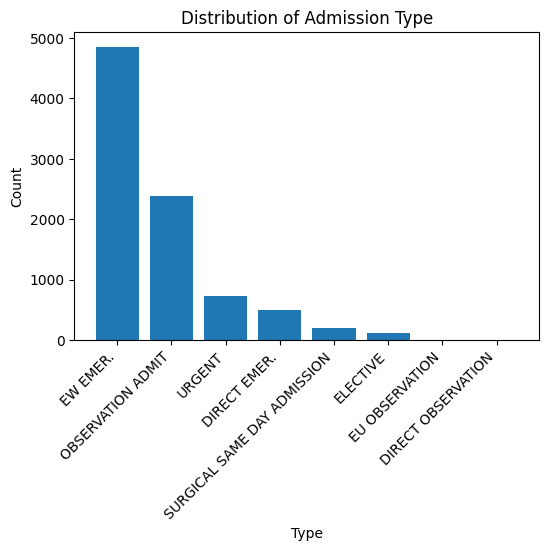

In [ ]:
# Distribution of admission type
counts = test_data['admission_type'].value_counts()

plt.figure(figsize=(6, 4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Distribution of Admission Type")
plt.xlabel("Type")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.show()

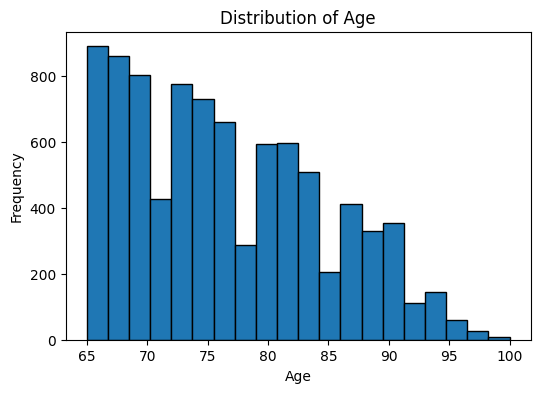

In [ ]:
# Distribution of age
plt.figure(figsize=(6, 4))
plt.hist(test_data['age'], bins=20, edgecolor='black')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

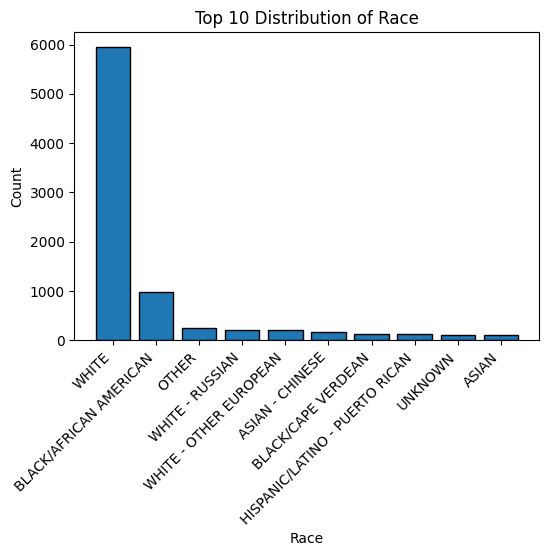

In [ ]:
# Distribution of race (top 10)
counts = test_data['race'].value_counts()

# Select the top 10 race categories
top_10_races = counts.head(10)

plt.figure(figsize=(6, 4))
plt.bar(top_10_races.index, top_10_races.values, edgecolor='black')
plt.title('Top 10 Distribution of Race')
plt.xlabel('Race')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

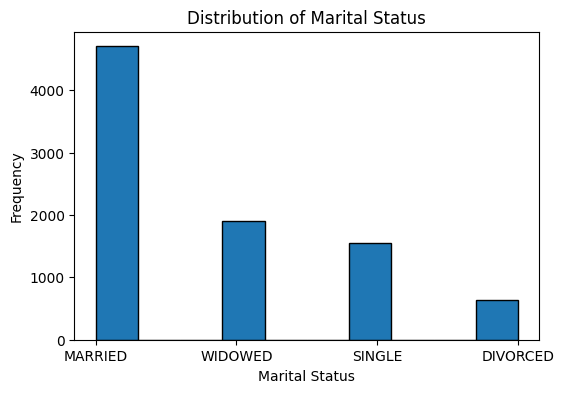

In [ ]:
# Distribution of marital status
plt.figure(figsize=(6, 4))
plt.hist(test_data['marital_status'], edgecolor='black')
plt.title('Distribution of Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Frequency')
plt.show()

## Model

### Base model

In [7]:
pip install pandas scikit-learn xgboost

In [8]:
TARGET   = "rehosp30d"
df = test_data.copy()

if TARGET not in df.columns:
    raise ValueError(f"Target '{TARGET}' not found. Available: {list(df.columns)}")

# cleaning + datetime features
datetime_cols = [
    "admittime","dischtime","deathtime","edregtime","edouttime",
    "nextadm30d_date","nextadm7d_date"
]
for c in datetime_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

def add_dt_feats(prefix, s):
    out = pd.DataFrame(index=s.index)
    out[f"{prefix}_year"]   = s.dt.year
    out[f"{prefix}_month"]  = s.dt.month
    out[f"{prefix}_dow"]    = s.dt.dayofweek
    out[f"{prefix}_hour"]   = s.dt.hour
    return out

# engineer timing features
extra_feats = []
if "admittime" in df.columns:
    extra_feats.append(add_dt_feats("admit", df["admittime"]))
if "dischtime" in df.columns:
    extra_feats.append(add_dt_feats("disch", df["dischtime"]))
if {"edregtime","edouttime"}.issubset(df.columns):
    ed_len_hours = (df["edouttime"] - df["edregtime"]).dt.total_seconds() / 3600.0
    extra_feats.append(pd.DataFrame({"ed_len_hours": ed_len_hours}))

if extra_feats:
    extra = pd.concat(extra_feats, axis=1)
    df = pd.concat([df, extra], axis=1)

# build feature list automatically
all_cols = df.columns.tolist()

# ID-like columns (no predictive signal)
id_cols = {"subject_id", "hadm_id", "admit_provider_id"}

# raw datetime columns (we already extracted features above)
raw_dt_cols = set([c for c in datetime_cols if c in df.columns])

# leakage columns (future info relative to prediction at discharge)
# keep onlythe chosen target; drop any other variants and their dates
def is_leak(col: str) -> bool:
    if col == TARGET:
        return True
    lc = col.lower()
    leak_prefixes = ("rehosp", "nextadm", "died")
    return lc.startswith(leak_prefixes)

leak_cols = {c for c in all_cols if is_leak(c)}

# build candidate features set
drop_cols = id_cols | raw_dt_cols | leak_cols | {TARGET}
feature_cols = [c for c in all_cols if c not in drop_cols]

print(f"Using {len(feature_cols)} features (showing first 25): {feature_cols[:25]}")

# X/y and train/test split
X = df[feature_cols].copy()
y = df[TARGET].astype(int)

mask = y.notna()
X, y = X.loc[mask], y.loc[mask]

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# type-aware preprocessing (auto-detect categorical vs numeric)
cat_sel = selector(dtype_include=["object","category"])
num_sel = selector(dtype_include=[np.number, "bool"])

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_sel),
        ("num", StandardScaler(),                         num_sel),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# XGBoost pipeline + tuning
xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

pipe_xgb = Pipeline([("prep", preprocess), ("model", xgb_base)])

# class imbalance handling: set scale_pos_weight
pos = int((y_tr == 1).sum()); neg = int((y_tr == 0).sum())
if pos > 0:
    spw = max(1.0, neg / pos)  # >=1
else:
    spw = 1.0

param_grid = {
    "model__n_estimators":     [300, 600, 900],
    "model__learning_rate":    [0.02, 0.05, 0.1],
    "model__max_depth":        [3, 4, 5],
    "model__min_child_weight": [1, 3, 5],
    "model__subsample":        [0.7, 0.85, 1.0],
    "model__colsample_bytree": [0.7, 0.85, 1.0],
    "model__gamma":            [0, 0.5, 1.0],
    "model__reg_lambda":       [0.5, 1.0, 2.0],
    "model__scale_pos_weight": [spw]  # fixed from training split
}

search = RandomizedSearchCV(
    estimator=pipe_xgb,
    param_distributions=param_grid,
    n_iter=25,                 # bump up for more thorough search
    scoring="roc_auc",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    refit=True
)

search.fit(X_tr, y_tr)

print("\nBest CV AUC:", round(search.best_score_, 3))
print("Best params:", search.best_params_)

# evaluate tuned model & show table
best_xgb = search.best_estimator_
p_te = best_xgb.predict_proba(X_te)[:, 1]

auc = roc_auc_score(y_te, p_te)
acc_05 = accuracy_score(y_te, (p_te >= 0.5).astype(int))

# scan for accuracy-maximizing threshold (optional)
ts = np.linspace(0, 1, 1001)
accs = [accuracy_score(y_te, (p_te >= t).astype(int)) for t in ts]
t_best = ts[int(np.argmax(accs))]
acc_best = max(accs)

print(f"\nTuned XGB — Test AUC: {auc:.3f}")
print(f"Tuned XGB — Accuracy @0.5: {acc_05:.3f}")
print(f"Tuned XGB — Best Accuracy: {acc_best:.3f} at threshold {t_best:.3f}")

# compact result table (sorted by risk)
out = pd.DataFrame({
    "prob_xgb": np.round(p_te, 3),
    "true":     y_te.to_numpy()
}).sort_values("prob_xgb", ascending=False).reset_index(drop=True)

print("\nPredicted Readmission Probabilities (test set, top 20):")
print(out.head(20).to_string(index=False))

Using 50 features (showing first 25): ['admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'marital_status', 'race', 'hospital_expire_flag', 'hosp_los', 'adm_inhosp', 'icd9_sepsiscode', 'icd9_septicshock', 'icd10_sepsiscode', 'icd10_septicshock', 'icd_version', 'icd9_angus', 'icd10_angus', 'icd9_angus_over', 'icd10_angus_over', 'icd9_sepsiscode_over', 'icd10_sepsiscode_over', 'sepsis', 'sepsistype', 'sepsistype_three', 'anchor_age']
Fitting 3 folds for each of 25 candidates, totalling 75 fits

Best CV AUC: 0.675
Best params: {'model__subsample': 0.7, 'model__scale_pos_weight': 2.4947033898305087, 'model__reg_lambda': 1.0, 'model__n_estimators': 300, 'model__min_child_weight': 1, 'model__max_depth': 3, 'model__learning_rate': 0.02, 'model__gamma': 0.5, 'model__colsample_bytree': 0.85}

Tuned XGB — Test AUC: 0.676
Tuned XGB — Accuracy @0.5: 0.643
Tuned XGB — Best Accuracy: 0.721 at threshold 0.747

Predicted Readmission Probabilities (test set, top 20):

In [ ]:
best_pipeline = search.best_estimator_

# extract the steps
prep_step = best_pipeline.named_steps["prep"]
xgb_step  = best_pipeline.named_steps["model"]

# get feature names and importances aligned automatically
importances = xgb_step.feature_importances_
feature_names = prep_step.get_feature_names_out()

# create a Dataframe/Series
feat_imp = pd.Series(data=importances, index=feature_names)

# show top 25
print("\nTop 25 Features by Importance (Gain):")
print(feat_imp.sort_values(ascending=False).head(25))

### TARGET = rehosp30d

In [9]:
TARGET   = "rehosp30d"
df = pd.read_csv('test_data.csv')

df = df[df[TARGET].notna()]
y = df[TARGET].astype(int)

# keep only selected features
selected_features = [
    "hosp_los",
    "ed_len_hours",
    "prev90d_hosp_sum",
    "admit_year",
    "age",
    "disch_hour",
    "anchor_age",
    "comorbidity",
    "admit_hour",
    "prev90d_hosp",
    "admit_month",
    "admit_dow",
    "disch_dow",
    "disch_year",
    "sepsistype",
    "icu_hx",
    "admission_type_DIRECT EMER.",
    "race_BLACK/CAPE VERDEAN",
    "disch_month",
    "admission_type_SURGICAL SAME DAY ADMISSION"
]

available = [c for c in selected_features if c in df.columns]
X = df[available].copy()

# preprocess
# treat object/category columns as categorical, rest as numeric
categorical = X.select_dtypes(include=["object","category"]).columns.tolist()
numeric     = X.select_dtypes(include=[np.number, "bool"]).columns.tolist()

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
    ("num", StandardScaler(), numeric),
])

# XGBoost with reasonable defaults)
xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=3,
    reg_lambda=1.0,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

pipe_xgb_small = Pipeline([("prep", preprocess), ("model", xgb)])

# train/test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

pipe_xgb_small.fit(X_tr, y_tr)

# evaluate
p_te = pipe_xgb_small.predict_proba(X_te)[:, 1]

auc = roc_auc_score(y_te, p_te)
acc_05 = accuracy_score(y_te, (p_te >= 0.5).astype(int))

print(f"\nReduced XGB — Test AUC: {auc:.3f}")
print(f"Reduced XGB — Accuracy @0.5: {acc_05:.3f}")

# sort patients by risk
out = pd.DataFrame({
    "prob_xgb_small": np.round(p_te, 3),
    "true": y_te.to_numpy()
}).sort_values("prob_xgb_small", ascending=False).reset_index(drop=True)

print("\nTop 20 predictions (small XGB model):")
print(out.head(20).to_string(index=False))


Reduced XGB — Test AUC: 0.636
Reduced XGB — Accuracy @0.5: 0.710

Top 20 predictions (small XGB model):
 prob_xgb_small  true
          0.846     1
          0.844     1
          0.829     0
          0.822     0
          0.821     1
          0.812     1
          0.795     1
          0.768     0
          0.764     0
          0.762     1
          0.759     0
          0.757     1
          0.754     0
          0.750     1
          0.750     1
          0.741     0
          0.737     0
          0.734     0
          0.725     0
          0.725     1


In [ ]:
# tuning
TARGET   = "rehosp30d"
df = pd.read_csv(CSV_PATH).copy()
df = df[df[TARGET].notna()]
y = df[TARGET].astype(int)

# reduced feature set
candidate_cols = [
    "hosp_los",
    "ed_len_hours",
    "prev90d_hosp_sum",
    "admit_year",
    "age",
    "disch_hour",
    "anchor_age",
    "comorbidity",
    "admit_hour",
    "prev90d_hosp",
    "admit_month",
    "admit_dow",
    "disch_dow",
    "disch_year",
    "sepsistype",
    "icu_hx",
    "admission_type_DIRECT EMER.",
    "race_BLACK/CAPE VERDEAN",
    "disch_month",
    "admission_type_SURGICAL SAME DAY ADMISSION"
]

available = [c for c in candidate_cols if c in df.columns]
if not available:
    raise ValueError("None of the selected reduced features are present in the CSV.")
X = df[available].copy()

# preprocessing
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number, "bool"]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# train/test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# XGBoost + RandomizedSearchCV (optimize ACCURACY)
pos = int((y_tr == 1).sum()); neg = int((y_tr == 0).sum())
spw = max(1.0, neg / max(pos, 1))

pipe = Pipeline([
    ("prep", preprocess),
    ("model", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=spw
    ))
])

param_distributions = {
    "model__n_estimators":     [200, 400, 600, 800],
    "model__learning_rate":    [0.02, 0.05, 0.1, 0.2],
    "model__max_depth":        [2, 3, 4, 5],
    "model__min_child_weight": [1, 3, 5, 7],
    "model__subsample":        [0.7, 0.85, 1.0],
    "model__colsample_bytree": [0.7, 0.85, 1.0],
    "model__gamma":            [0, 0.5, 1.0, 2.0],
    "model__reg_lambda":       [0.0, 0.5, 1.0, 2.0],
    "model__reg_alpha":        [0.0, 0.1, 0.5]
}

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=40,                 # increase for a deeper search
    scoring="accuracy",
    cv=5,                      # 5-fold CV
    random_state=42,
    n_jobs=-1,
    verbose=1,
    refit=True                 # refit best pipeline on full train split
)

search.fit(X_tr, y_tr)
best_model = search.best_estimator_
print("\nBest CV Accuracy:", round(search.best_score_, 3))
print("Best Params:", search.best_params_)

# evaluate on test
probs = best_model.predict_proba(X_te)[:, 1]

# accuracy at default 0.5
acc_05 = accuracy_score(y_te, (probs >= 0.5).astype(int))

ts = np.linspace(0, 1, 1001)
accs = [accuracy_score(y_te, (probs >= t).astype(int)) for t in ts]
t_best = ts[int(np.argmax(accs))]
acc_best = max(accs)

auc = roc_auc_score(y_te, probs)

print(f"\nTest Accuracy @0.5: {acc_05:.3f}")
print(f"Best Test Accuracy: {acc_best:.3f} at threshold {t_best:.3f}")
print(f"Test AUC: {auc:.3f}")

# show table (top 20 by risk)
out = pd.DataFrame({
    "prob_xgb_tuned": np.round(probs, 3),
    "true": y_te.to_numpy()
}).sort_values("prob_xgb_tuned", ascending=False).reset_index(drop=True)

print("\nTop 20 predictions:")
print(out.head(100).to_string(index=False))

### TARGET = rehosp7d

In [ ]:
TARGET   = "rehosp7d"
df = pd.read_csv(CSV_PATH).copy()
df = df[df[TARGET].notna()]
y = df[TARGET].astype(int)

# reduced feature set
candidate_cols = [
    "hosp_los",
    "ed_len_hours",
    "prev90d_hosp_sum",
    "admit_year",
    "age",
    "disch_hour",
    "anchor_age",
    "comorbidity",
    "admit_hour",
    "prev90d_hosp",
    "admit_month",
    "admit_dow",
    "disch_dow",
    "disch_year",
    "sepsistype",
    "icu_hx",
    "admission_type_DIRECT EMER.",
    "race_BLACK/CAPE VERDEAN",
    "disch_month",
    "admission_type_SURGICAL SAME DAY ADMISSION"
]

available = [c for c in candidate_cols if c in df.columns]
if not available:
    raise ValueError("None of the selected reduced features are present in the CSV.")
X = df[available].copy()

# preprocessing
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number, "bool"]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# train/test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# XGBoost + RandomizedSearchCV (optimize ACCURACY)
pos = int((y_tr == 1).sum()); neg = int((y_tr == 0).sum())
spw = max(1.0, neg / max(pos, 1))

pipe = Pipeline([
    ("prep", preprocess),
    ("model", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=spw
    ))
])

param_distributions = {
    "model__n_estimators":     [200, 400, 600, 800],
    "model__learning_rate":    [0.02, 0.05, 0.1, 0.2],
    "model__max_depth":        [2, 3, 4, 5],
    "model__min_child_weight": [1, 3, 5, 7],
    "model__subsample":        [0.7, 0.85, 1.0],
    "model__colsample_bytree": [0.7, 0.85, 1.0],
    "model__gamma":            [0, 0.5, 1.0, 2.0],
    "model__reg_lambda":       [0.0, 0.5, 1.0, 2.0],
    "model__reg_alpha":        [0.0, 0.1, 0.5]
}

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=40,                 # increase for a deeper search
    scoring="accuracy",
    cv=5,                      # 5-fold CV
    random_state=42,
    n_jobs=-1,
    verbose=1,
    refit=True                 # refit best pipeline on full train split
)

search.fit(X_tr, y_tr)
best_model = search.best_estimator_
print("\nBest CV Accuracy:", round(search.best_score_, 3))
print("Best Params:", search.best_params_)

# evaluation
probs = best_model.predict_proba(X_te)[:, 1]

# accuracy at default 0.5
acc_05 = accuracy_score(y_te, (probs >= 0.5).astype(int))

ts = np.linspace(0, 1, 1001)
accs = [accuracy_score(y_te, (probs >= t).astype(int)) for t in ts]
t_best = ts[int(np.argmax(accs))]
acc_best = max(accs)

auc = roc_auc_score(y_te, probs)

print(f"\nTest Accuracy @0.5: {acc_05:.3f}")
print(f"Best Test Accuracy: {acc_best:.3f} at threshold {t_best:.3f}")
print(f"Test AUC: {auc:.3f}")

# table
out = pd.DataFrame({
    "prob_xgb_tuned": np.round(probs, 3),
    "true": y_te.to_numpy()
}).sort_values("prob_xgb_tuned", ascending=False).reset_index(drop=True)

print("\nTop 20 predictions:")
print(out.head(10).to_string(index=False))

In [ ]:
from sklearn.metrics import classification_report

for t in [0.3, 0.4, 0.5]:
    y_pred_t = (probs >= t).astype(int)
    print(f"\nThreshold {t}")
    print(classification_report(y_te, y_pred_t, digits=3))


In [ ]:
print("\nPercentage distribution:")
print((df["rehosp7d"].value_counts(normalize=True) * 100).round(2))

In [ ]:
import matplotlib.pyplot as plt
plt.hist(probs, bins=50, edgecolor="k")
plt.xlabel("Predicted probability")
plt.ylabel("Count")
plt.title("Distribution of predicted probabilities")
plt.show()

### SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

X_res, y_res = SMOTE(random_state=42).fit_resample(X, y)
print("Balanced class counts:", dict(pd.Series(y_res).value_counts()))

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                               recall_score, f1_score, confusion_matrix,
                               classification_report)

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


CSV_PATH = "test_data.csv"
TARGET   = "rehosp7d"

df = pd.read_csv(CSV_PATH)

if TARGET not in df.columns:
    raise ValueError(f"Target '{TARGET}' not found. Available: {list(df.columns)}")

# drop rows with missing target
df = df[df[TARGET].notna()].copy()
y = df[TARGET].astype(int)

# datetime → engineered features
for c in ["admittime","dischtime","edregtime","edouttime"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

def add_dt_feats(prefix, s):
    out = pd.DataFrame(index=s.index)
    out[f"{prefix}_year"]  = s.dt.year
    out[f"{prefix}_month"] = s.dt.month
    out[f"{prefix}_dow"]   = s.dt.dayofweek
    out[f"{prefix}_hour"]  = s.dt.hour
    return out

extra = []
if "admittime" in df.columns:
    extra.append(add_dt_feats("admit", df["admittime"]))
if "dischtime" in df.columns:
    extra.append(add_dt_feats("disch", df["dischtime"]))
if {"edregtime","edouttime"}.issubset(df.columns):
    ed_len_hours = (df["edouttime"] - df["edregtime"]).dt.total_seconds()/3600.0
    extra.append(pd.DataFrame({"ed_len_hours": ed_len_hours}, index=df.index))

if extra:
    df = pd.concat([df] + extra, axis=1)

# feature set; use RAW columns
candidate_cols = [
    # numerics / engineered numerics
    "hosp_los", "ed_len_hours", "prev90d_hosp_sum",
    "admit_year", "age", "disch_hour", "anchor_age", "comorbidity",
    "admit_hour", "prev90d_hosp", "admit_month", "admit_dow",
    "disch_dow", "disch_year", "icu_hx",
    # categoricals (raw)
    "sepsistype", "race", "admission_type",
    "dod_nan"
]
available = [c for c in candidate_cols if c in df.columns]
if not available:
    raise ValueError("None of the selected reduced features are present in the CSV.")
X = df[available].copy()

# train / Test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Class balance before SMOTE (train split):",
      dict(pd.Series(y_tr).value_counts()))

# preprocess → ompute → SMOTE → XGBoost
cat_cols = X_tr.select_dtypes(include=["object","category"]).columns.tolist()
num_cols = X_tr.select_dtypes(include=[np.number, "bool"]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

imputer = SimpleImputer(strategy='mean')

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
    n_estimators=400,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=3,
    reg_lambda=1.0
)

# SMOTE is placed after preprocessing and before the model
pipe = ImbPipeline(steps=[
    ("prep", preprocess),
    ("impute", imputer),
    ("smote", SMOTE(random_state=42)),
    ("model", xgb)
])

# fit model
pipe.fit(X_tr, y_tr)

# show post-SMOTE class counts
Xt_prep = pipe.named_steps["prep"].transform(X_tr)
Xt_imputed = pipe.named_steps["impute"].transform(Xt_prep) # impute after preprocessing
X_res, y_res = pipe.named_steps["smote"].fit_resample(Xt_imputed, y_tr) # SMOTE on imputed data
print("Class balance after SMOTE (train transformed):",
      dict(pd.Series(y_res).value_counts()))


# evaluation
probs = pipe.predict_proba(X_te)[:, 1]
pred05 = (probs >= 0.5).astype(int)

auc = roc_auc_score(y_te, probs)
acc = accuracy_score(y_te, pred05)
prec = precision_score(y_te, pred05)
rec  = recall_score(y_te, pred05)
f1   = f1_score(y_te, pred05)

print(f"\nXGB + SMOTE — Test AUC: {auc:.3f}")
print(f"XGB + SMOTE — Accuracy @0.5: {acc:.3f}")
print(f"XGB + SMOTE — Precision @0.5: {prec:.3f}")
print(f"XGB + SMOTE — Recall @0.5: {rec:.3f}")
print(f"XGB + SMOTE — F1 @0.5: {f1:.3f}")

cm = confusion_matrix(y_te, pred05)
print("\nConfusion matrix @0.5:\n", cm)
print("\nClassification report @0.5:\n",
        classification_report(y_te, pred05, digits=3))

ts = np.linspace(0, 1, 1001)
accs = [accuracy_score(y_te, (probs >= t).astype(int)) for t in ts]
best_t_acc = ts[int(np.argmax(accs))]
best_acc = max(accs)
print(f"\nBest Test Accuracy: {best_acc:.3f} at threshold {best_t_acc:.3f}")

# probability table (top 20 by risk)
out = pd.DataFrame({
    "prob_xgb_smote": np.round(probs, 3),
    "true": y_te.to_numpy()
}).sort_values("prob_xgb_smote", ascending=False).reset_index(drop=True)

print("\nTop 20 predictions (XGB + SMOTE):")
print(out.head(20).to_string(index=False))

In [ ]:
plt.hist(probs, bins=50, edgecolor="k")
plt.xlabel("Predicted probability")
plt.ylabel("Count")
plt.title("Distribution of predicted probabilities")
plt.show()

In [ ]:
out

## Final Model

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                               recall_score, f1_score, confusion_matrix,
                               classification_report)

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# load data
CSV_PATH = "test_data.csv"
TARGET   = "rehosp7d"

df = pd.read_csv(CSV_PATH)

if TARGET not in df.columns:
    raise ValueError(f"Target '{TARGET}' not found. Available: {list(df.columns)}")

# drop rows with missing target
df = df[df[TARGET].notna()].copy()
y = df[TARGET].astype(int)

# dDatetime → engineered features
for c in ["admittime","dischtime","edregtime","edouttime"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

def add_dt_feats(prefix, s):
    out = pd.DataFrame(index=s.index)
    out[f"{prefix}_year"]  = s.dt.year
    out[f"{prefix}_month"] = s.dt.month
    out[f"{prefix}_dow"]   = s.dt.dayofweek
    out[f"{prefix}_hour"]  = s.dt.hour
    return out

extra = []
if "admittime" in df.columns:
    extra.append(add_dt_feats("admit", df["admittime"]))
if "dischtime" in df.columns:
    extra.append(add_dt_feats("disch", df["dischtime"]))
if {"edregtime","edouttime"}.issubset(df.columns):
    ed_len_hours = (df["edouttime"] - df["edregtime"]).dt.total_seconds()/3600.0
    extra.append(pd.DataFrame({"ed_len_hours": ed_len_hours}, index=df.index))

if extra:
    df = pd.concat([df] + extra, axis=1)

# feature set
candidate_cols = [
   "hosp_los",
   "ed_len_hours",
   "prev90d_hosp_sum",
   "age",
   "comorbidity",
   "prev90d_hosp",
   "sepsistype",
   "icu_hx",
   "admission_type", # raw categorical column
   "race", # raw categorical column
   "admission_type_DIRECT EMER.",
   "race_BLACK/CAPE VERDEAN",
   "admission_type_SURGICAL SAME DAY ADMISSION"
]

# Filter to only include columns present in the DataFrame
available = [c for c in candidate_cols if c in df.columns]

raw_cat_cols_for_pipeline = [c for c in available if c in ["admission_type", "race", "sepsistype"]]
raw_num_cols_for_pipeline = [c for c in available if c not in raw_cat_cols_for_pipeline]


if not available:
    raise ValueError("None of the selected reduced features are present in the CSV.")
X = df[available].copy()


# train / Test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Class balance before SMOTE (train split):",
      dict(pd.Series(y_tr).value_counts()))

# preprocess → impute → SMOTE → XGBoost
preprocess = ColumnTransformer(
    transformers=[
        # apply imputation and scaling to numerical columns
        ("num", Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), raw_num_cols_for_pipeline),
        # apply one-hot encoding to categorical columns
        ("cat", OneHotEncoder(handle_unknown="ignore"), raw_cat_cols_for_pipeline),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)


xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
    n_estimators=400,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=3,
    reg_lambda=1.0
)

pipe = ImbPipeline(steps=[
    ("prep", preprocess),
    ("smote", SMOTE(random_state=42)),
    ("model", xgb)
])

# fit
pipe.fit(X_tr, y_tr)

Xt_prep_imputed = pipe.named_steps["prep"].transform(X_tr)
X_res, y_res = pipe.named_steps["smote"].fit_resample(Xt_prep_imputed, y_tr)
print("Class balance after SMOTE (train transformed):",
      dict(pd.Series(y_res).value_counts()))


# evaluate
probs = pipe.predict_proba(X_te)[:, 1]
pred05 = (probs >= 0.5).astype(int)

auc = roc_auc_score(y_te, probs)
acc = accuracy_score(y_te, pred05)
prec = precision_score(y_te, pred05)
rec  = recall_score(y_te, pred05)
f1   = f1_score(y_te, pred05)

print(f"\nXGB + SMOTE — Test AUC: {auc:.3f}")
print(f"XGB + SMOTE — Accuracy @0.5: {acc:.3f}")
print(f"XGB + SMOTE — Precision @0.5: {prec:.3f}")
print(f"XGB + SMOTE — Recall @0.5: {rec:.3f}")
print(f"XGB + SMOTE — F1 @0.5: {f1:.3f}")

cm = confusion_matrix(y_te, pred05)
print("\nConfusion matrix @0.5:\n", cm)
print("\nClassification report @0.5:\n",
        classification_report(y_te, pred05, digits=3))

ts = np.linspace(0, 1, 1001)
accs = [accuracy_score(y_te, (probs >= t).astype(int)) for t in ts]
best_t_acc = ts[int(np.argmax(accs))]
best_acc = max(accs)
print(f"\nBest Test Accuracy: {best_acc:.3f} at threshold {best_t_acc:.3f}")

# probability table (top 20 by risk)
out = pd.DataFrame({
    "prob_xgb_smote": np.round(probs, 3),
    "true": y_te.to_numpy()
}).sort_values("prob_xgb_smote", ascending=False).reset_index(drop=True)

print("\nTop 20 predictions (XGB + SMOTE):")
print(out.head(20).to_string(index=False))

In [ ]:
# check
print("y_tr counts (before SMOTE):")
print(y_tr.value_counts())

# transform X_tr the same way the pipeline does before SMOTE
Xt = pipe.named_steps["prep"].fit_transform(X_tr)   # fit on train only
# apply the imputer before applying SMOTE
Xt_imputed = pipe.named_steps["impute"].transform(Xt)

sm = pipe.named_steps["smote"]

# apply SMOTE to get the resampled matrices (for inspection only)
Xt_res, y_res = sm.fit_resample(Xt_imputed, y_tr)

print("\ny_res counts (after SMOTE):")
print(pd.Series(y_res).value_counts())

added_total = len(y_res) - len(y_tr)
print(f"\nTotal samples added by SMOTE: {added_total}")

before = y_tr.value_counts().to_dict()
after  = pd.Series(y_res).value_counts().to_dict()
added_per_class = {k: after.get(k,0) - before.get(k,0) for k in set(after)|set(before)}
print("Samples added per class:", added_per_class)

In [ ]:
import matplotlib.pyplot as plt
plt.hist(probs, bins=50, edgecolor="k")
plt.xlabel("Predicted probability")
plt.ylabel("Count")
plt.title("Distribution of predicted probabilities")
plt.show()

In [ ]:
import numpy as np
import pandas as pd

PROB_COL = "prob_xgb_smote"

# create risk band + a high-risk flag
out["risk_level"] = np.select(
    [
        out[PROB_COL] > 0.5,
        (out[PROB_COL] >= 0.30) & (out[PROB_COL] <= 0.5),
        out[PROB_COL] < 0.30
    ],
    ["High", "Medium", "Low"],
    default="Low"
)

out["high_risk_flag"] = (out[PROB_COL] > 0.65).astype(int)

# summary
print(out["risk_level"].value_counts().reindex(["High","Medium","Low"]).fillna(0).astype(int))
print("\nPreview:")
print(out[[PROB_COL, "risk_level", "high_risk_flag"]].head(10))

In [ ]:
out['risk_level'].value_counts()

In [ ]:
import matplotlib.pyplot as plt

col = "risk_level"

counts = out[col].value_counts().reindex(["High", "Medium", "Low"]).fillna(0)

# Plot
plt.figure(figsize=(6,4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Risk Level Distribution")
plt.xlabel("Risk Level")
plt.ylabel("Count")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

selected_features = [
    "hosp_los","ed_len_hours","prev90d_hosp_sum","age","comorbidity", "rehosp7d", "prev90d_hosp",
   "sepsistype",
   "icu_hx",
   "admission_type_DIRECT EMER.",
   "race_BLACK/CAPE VERDEAN",
   "admission_type_SURGICAL SAME DAY ADMISSION"
    ]

# subset to available columns
feats = [c for c in selected_features if c in df.columns]
df_sel = df[feats].copy()

# split numeric vs categorical
cat_cols = df_sel.select_dtypes(include=["object","category"]).columns.tolist()
num_cols = [c for c in df_sel.columns if c not in cat_cols]

# ensure numerics are numeric; impute median for NaNs
df_num = df_sel[num_cols].apply(pd.to_numeric, errors="coerce")
for c in df_num.columns:
    df_num[c] = df_num[c].fillna(df_num[c].median())

# One-hot encode categoricals
if cat_cols:
    df_cat = pd.get_dummies(
        df_sel[cat_cols].astype("category"),
        dummy_na=True,
        drop_first=False
    )
else:
    df_cat = pd.DataFrame(index=df_sel.index)

# combine; drop constant columns
corr_input = pd.concat([df_num, df_cat], axis=1)
constant_cols = [c for c in corr_input.columns if corr_input[c].nunique(dropna=True) <= 1]
if constant_cols:
    corr_input = corr_input.drop(columns=constant_cols)

# Pearson correlation matrix
corr = corr_input.corr(method="pearson")

# table
print("Correlation matrix (Pearson):")
print(corr.round(3))

# heatmap
plt.figure(figsize=(10, 8))
im = plt.imshow(corr.values, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation Matrix (Pearson)")
plt.tight_layout()
plt.show()